In [26]:
######################################
### 1.sentence encoder = RNN
### 2.interaction = Local inference modeling = softmax+attention && Enhancement  ==> soft_align_attention
### 3.classifier =  RNN + max_avg_pooling + MLP
### 4.RNN+pack/pad & attention+mask
##### https://github.com/coetaur0/ESIM/blob/master/esim
######################################

In [27]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
import nltk
import pickle
from nltk import pos_tag
from scipy import spatial
from scipy.sparse import hstack, vstack
from sklearn.datasets import dump_svmlight_file,load_svmlight_file
from sklearn.decomposition import TruncatedSVD
import xgboost as xgb
import gensim
from gensim.models import TfidfModel
from gensim.corpora import Dictionary
from scipy import spatial
import multiprocessing
import math
import matplotlib.pyplot as plt

data_path = "/media/data/cuixuange/competition_2019/first_round/data/"
feature_path = "/media/data/cuixuange/competition_2019/first_round/feature/"
model_path = "/media/data/cuixuange/competition_2019/first_round/model/"

In [28]:
w2vmodel = pickle.load(open(model_path+"word2vec_model.pkl","rb"))
from gensim.models import KeyedVectors
save_path = model_path + "w2v_vector.kv"
w2vmodel.wv.save(save_path)
word_vectors = KeyedVectors.load(save_path, mmap='r')


In [29]:
################################################# pretrain_embedding
################################################# pretrain_embedding
################################################# pretrain_embedding
word_dim = 100
pre_emb_len = len(word_vectors.vocab.keys()) + 1
pre_emb_matrix = np.zeros((pre_emb_len,word_dim))
pre_reindex_dict = dict()
reindex = 1
for key,_ in word_vectors.vocab.items():
    pre_emb_matrix[reindex] = word_vectors[key] #填充pretrained_emb
    pre_reindex_dict[key] = reindex #key:单词值 value:embedding index
    reindex += 1

print(pre_emb_matrix.shape,type(pre_emb_matrix))
# for k,v in pre_reindex_dict.items():
#     print(k,"\t:",v)

(10148, 100) <class 'numpy.ndarray'>


In [30]:
############################################ dataset
############################################ dataset
############################################ dataset
import torch
from torch.utils.data import Dataset,DataLoader
colnames = ["query_id","query","query_title_id","title","label"]
train_data_path = data_path+"train_data.sample"
cores = multiprocessing.cpu_count()-1
sentence_limit = 36
word_dim = 100
############ valid
train_index = pickle.load(open(data_path+"train.index.pkl", "rb")) 
valid_index = pickle.load(open(data_path+"valid.index.pkl", "rb")) 

def get_seq_list(word_list):
    seq_list = np.zeros(sentence_limit)#序号0对应embedding层的零向量
    exits_word_count = 0
    for val in word_list:
        if exits_word_count < sentence_limit:
            try:
                seq_list[exits_word_count] = pre_reindex_dict[val] #reindex
            except:
                continue  
        else:
            break
        exits_word_count += 1
    if exits_word_count==0: exits_word_count=1  #长度最少为1
    return seq_list,exits_word_count

class Dataset(torch.utils.data.Dataset):
    def __init__(self, filepath=None):
        self.data =  pd.read_csv(filepath,names=colnames,header=None,lineterminator="\n").iloc[train_index]
        self.lgb_data =  pd.read_csv(feature_path+"combine_feature.csv", header=None,lineterminator="\n").iloc[train_index]
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        row = self.data.iloc[index]
        query,q_len = get_seq_list(str(row[1]).split(" "))    
        title,t_len = get_seq_list(str(row[3]).split(" "))
        label = row[4]
        lgb_feature = self.lgb_data.iloc[index]
        return query,q_len,title,t_len,label,np.hstack((lgb_feature,lgb_feature))
    
class test_Dataset(torch.utils.data.Dataset):
    def __init__(self, filepath=None):
        self.data =  pd.read_csv(filepath,names=colnames,header=None,lineterminator="\n").iloc[train_index]
        self.lgb_data =  pd.read_csv(feature_path+"combine_feature.csv", header=None,lineterminator="\n").iloc[train_index]
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        row = self.data.iloc[index]
        query,q_len = get_seq_list(str(row[1]).split(" "))    
        title,t_len = get_seq_list(str(row[3]).split(" "))
        label = row[4]
        lgb_feature = self.lgb_data.iloc[index]
        return query,q_len,title,t_len,label,np.hstack((lgb_feature,lgb_feature))
    
train_dataset = Dataset(train_data_path)
test_dataset = test_Dataset(train_data_path)

In [31]:
############################################ dataloader collect_fn 
############################################ dataloader collect_fn 
############################################ dataloader collect_fn 
batch_size = 256

def my_collate_padding(batch_list,dim2pad=0):
    """
    query,title,label分别进行padding操作(句子长度不是等长的)
    input: list of __getitem__ data
    output: merge data to batch
    """
    list_query,list_q_len,list_title,list_t_len,list_label,list_lgb_feature = zip(*batch_list)
    batch_size = len(batch_list) # 最后一个的batchsize是不完整的,这里的batchsize需要调整
    pad_query = np.zeros((batch_size, sentence_limit))
    pad_title = np.zeros((batch_size, sentence_limit))
    for i, tmp in enumerate(list_query):
        pad_query[i] = tmp
    for i, tmp in enumerate(list_title):
        pad_title[i] = tmp
    return  pad_query,np.array(list_q_len),pad_title,np.array(list_t_len),np.array(list_label),np.array(list_lgb_feature)


train_data_generator = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,collate_fn=my_collate_padding,
                                          shuffle=False, sampler=None, batch_sampler=None, 
                                          num_workers=0, pin_memory=False, drop_last=False)

test_data_generator = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,collate_fn=my_collate_padding,
                                          shuffle=False, sampler=None, batch_sampler=None, 
                                          num_workers=0, pin_memory=False, drop_last=False)

dataloader_iterator = iter(train_data_generator)
batch_q,batch_q_len,batch_t,batch_t_len,batch_l,batch_lgb = dataloader_iterator.next()
print(batch_q.shape)
print(batch_q_len.shape)
print(batch_t.shape)
print(batch_t_len.shape)
print(batch_l.shape)
print(batch_lgb.shape)
print(batch_q[0])
print(batch_t[1])

(256, 36)
(256,)
(256, 36)
(256,)
(256,)
(256, 94)
[ 1.  2.  3.  1.  4.  5.  6.  7.  8.  9. 10. 11. 10. 12. 13.  7. 14. 15.
 16. 17. 18. 19. 20. 21. 22. 12. 23. 24. 25. 26. 27. 28. 29. 28.  0.  0.]
[ 6.  7.  8.  9. 43. 51. 44. 12. 13.  7. 14. 15. 16. 17.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


In [32]:
######################################################################################
#######  Utils 函数
###################################################################################### 
# Code widely inspired from:
# https://github.com/allenai/allennlp/blob/master/allennlp/nn/util.py.
def sort_by_seq_lens(batch, sequences_lengths, descending=True):
    """
    Sort a batch of padded variable length sequences by their length.
    Args:
        batch: A batch of padded variable length sequences. The batch should
            have the dimensions (batch_size x max_sequence_length x *).
        sequences_lengths: A tensor containing the lengths of the sequences in the
            input batch. The tensor should be of size (batch_size).
        descending: A boolean value indicating whether to sort the sequences
            by their lengths in descending order. Defaults to True.
    Returns:
        sorted_batch: A tensor containing the input batch reordered by
            sequences lengths.
        sorted_seq_lens: A tensor containing the sorted lengths of the
            sequences in the input batch.
        sorting_idx: A tensor containing the indices used to permute the input
            batch in order to get 'sorted_batch'.
        restoration_idx: A tensor containing the indices that can be used to
            restore the order of the sequences in 'sorted_batch' so that it
            matches the input batch.
    """
    sorted_seq_lens, sorting_index =\
        sequences_lengths.sort(0, descending=descending)

    sorted_batch = batch.index_select(0, sorting_index)

    idx_range =\
        sequences_lengths.new_tensor(torch.arange(0, len(sequences_lengths)))
    _, reverse_mapping = sorting_index.sort(0, descending=False)
    restoration_index = idx_range.index_select(0, reverse_mapping)

    return sorted_batch, sorted_seq_lens, sorting_index, restoration_index


def get_mask(sequences_batch, sequences_lengths):
    """
    Get the mask for a batch of padded variable length sequences.
    Args:
        sequences_batch: A batch of padded variable length sequences
            containing word indices. Must be a 2-dimensional tensor of size
            (batch, sequence).
        sequences_lengths: A tensor containing the lengths of the sequences in
            'sequences_batch'. Must be of size (batch).
    Returns:
        A mask of size (batch, max_sequence_length), where max_sequence_length
        is the length of the longest sequence in the batch.
    """
    batch_size = sequences_batch.size()[0]
    max_length = torch.max(sequences_lengths)
    mask = torch.ones(batch_size, max_length, dtype=torch.float)
    mask[sequences_batch[:, :max_length] == 0] = 0.0
    return mask


# Code widely inspired from:
# https://github.com/allenai/allennlp/blob/master/allennlp/nn/util.py.
def masked_softmax(tensor, mask):
    """
    Apply a masked softmax on the last dimension of a tensor.
    The input tensor and mask should be of size (batch, *, sequence_length).
    Args:
        tensor: The tensor on which the softmax function must be applied along
            the last dimension.
        mask: A mask of the same size as the tensor with 0s in the positions of
            the values that must be masked and 1s everywhere else.
    Returns:
        A tensor of the same size as the inputs containing the result of the
        softmax.
    """
    tensor_shape = tensor.size()
    reshaped_tensor = tensor.view(-1, tensor_shape[-1])

    # Reshape the mask so it matches the size of the input tensor.
    while mask.dim() < tensor.dim():
        mask = mask.unsqueeze(1)
    mask = mask.expand_as(tensor).contiguous().float()
    reshaped_mask = mask.view(-1, mask.size()[-1])

    result = nn.functional.softmax(reshaped_tensor * reshaped_mask, dim=-1)
    result = result * reshaped_mask
    # 1e-13 is added to avoid divisions by zero.
    result = result / (result.sum(dim=-1, keepdim=True) + 1e-13)

    return result.view(*tensor_shape)


# Code widely inspired from:
# https://github.com/allenai/allennlp/blob/master/allennlp/nn/util.py.
def weighted_sum(tensor, weights, mask):
    """
    Apply a weighted sum on the vectors along the last dimension of 'tensor',
    and mask the vectors in the result with 'mask'.
    Args:
        tensor: A tensor of vectors on which a weighted sum must be applied.
        weights: The weights to use in the weighted sum.
        mask: A mask to apply on the result of the weighted sum.
    Returns:
        A new tensor containing the result of the weighted sum after the mask
        has been applied on it.
    """
    weighted_sum = weights.bmm(tensor)

    while mask.dim() < weighted_sum.dim():
        mask = mask.unsqueeze(1)
    mask = mask.transpose(-1, -2)
    mask = mask.expand_as(weighted_sum).contiguous().float()

    return weighted_sum * mask

In [33]:
######################################################################################
#######  Layer层的继承 + forword函数
###################################################################################### 
import torch
import torch.nn as nn
class Seq2SeqEncoder(nn.Module):
    """
    RNN taking variable length padded sequences of vectors as input and
    encoding them into padded sequences of vectors of the same length.
    This module is useful to handle batches of padded sequences of vectors
    that have different lengths and that need to be passed through a RNN.
    The sequences are sorted in descending order of their lengths, packed,
    passed through the RNN, and the resulting sequences are then padded and
    permuted back to the original order of the input sequences.
    """

    def __init__(self,
                 rnn_type,
                 input_size,
                 hidden_size,
                 num_layers=1,
                 bias=True,
                 dropout=0.0,
                 bidirectional=False): 
        """
        Args:
            rnn_type: The type of RNN to use as encoder in the module.
                Must be a class inheriting from torch.nn.RNNBase
                (such as torch.nn.LSTM for example).
            input_size: The number of expected features in the input of the
                module.
            hidden_size: The number of features in the hidden state of the RNN
                used as encoder by the module.
            num_layers: The number of recurrent layers in the encoder of the
                module. Defaults to 1.
            bias: If False, the encoder does not use bias weights b_ih and
                b_hh. Defaults to True.
            dropout: If non-zero, introduces a dropout layer on the outputs
                of each layer of the encoder except the last one, with dropout
                probability equal to 'dropout'. Defaults to 0.0.
            bidirectional: If True, the encoder of the module is bidirectional.
                Defaults to False.
        """
        assert issubclass(rnn_type, nn.RNNBase),\
            "rnn_type must be a class inheriting from torch.nn.RNNBase"

        super(Seq2SeqEncoder, self).__init__()

        self.rnn_type = rnn_type
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bias = bias
        self.dropout = dropout
        self.bidirectional = bidirectional

        self._encoder = rnn_type(input_size,
                                 hidden_size,
                                 num_layers=num_layers,
                                 bias=bias,
                                 batch_first=True,
                                 dropout=dropout,
                                 bidirectional=bidirectional)

    def forward(self, sequences_batch, sequences_lengths):
        """
        Args:
            sequences_batch: A batch of variable length sequences of vectors.
                The batch is assumed to be of size
                (batch, sequence, vector_dim).
            sequences_lengths: A 1D tensor containing the sizes of the
                sequences in the input batch.
        Returns:
            reordered_outputs: The outputs (hidden states) of the encoder for
                the sequences in the input batch, in the same order.
        """
        packed_batch = nn.utils.rnn.pack_padded_sequence(sequences_batch, sequences_lengths, 
                                                                 batch_first=True,enforce_sorted=False)
        outputs, _ = self._encoder(packed_batch.float(), None)  #Bi-LSTM训练，pack/pad
        paded_batch, _ = nn.utils.rnn.pad_packed_sequence(outputs,batch_first=True) #sequence = batch max_length
        return paded_batch
    
    
class SoftmaxAttention(nn.Module):
    """
    Attention layer taking premises and hypotheses encoded by an RNN as input
    and computing the soft attention between their elements.
    The dot product of the encoded vectors in the premises and hypotheses is
    first computed. The softmax of the result is then used in a weighted sum
    of the vectors of the premises for each element of the hypotheses, and
    conversely for the elements of the premises.
    """

    def forward(self,
                premise_batch,
                premise_mask,
                hypothesis_batch,
                hypothesis_mask):
        """
        Args:
            premise_batch: A batch of sequences of vectors representing the
                premises in some NLI task. The batch is assumed to have the
                size (batch, sequences, vector_dim).
            premise_mask: A mask for the sequences in the premise batch, to
                ignore padding data in the sequences during the computation of
                the attention.
            hypothesis_batch: A batch of sequences of vectors representing the
                hypotheses in some NLI task. The batch is assumed to have the
                size (batch, sequences, vector_dim).
            hypothesis_mask: A mask for the sequences in the hypotheses batch,
                to ignore padding data in the sequences during the computation
                of the attention.
        Returns:
            attended_premises: The sequences of attention vectors for the
                premises in the input batch.
            attended_hypotheses: The sequences of attention vectors for the
                hypotheses in the input batch.
        """
        # 1.Dot product  = batch * seq_q * seq_t
        similarity_matrix = premise_batch.bmm(hypothesis_batch.transpose(2, 1).contiguous())

        # 2. Softmax similarity (1.query_softmax * mask 2.title的softmax按照列计算)
        prem_hyp_attn = masked_softmax(similarity_matrix, hypothesis_mask)
        hyp_prem_attn = masked_softmax(similarity_matrix.transpose(1, 2).contiguous(),premise_mask)

        # 3.Attention (softmax_weights * other_batch)
        attended_premises = weighted_sum(hypothesis_batch,prem_hyp_attn,premise_mask)
        attended_hypotheses = weighted_sum(premise_batch,hyp_prem_attn,hypothesis_mask)
        
        # 4. batch * seq * word_dim
        return attended_premises, attended_hypotheses

In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class ESIM_Embed_Sparse(nn.Module):
    
    def __init__(self):
        super(ESIM_Embed_Sparse, self).__init__()
        #0.Embedding layer
        self._embed_layer = nn.Embedding(num_embeddings=pre_emb_len,embedding_dim=word_dim,
                                        sparse=True,padding_idx=0,_weight=torch.tensor(pre_emb_matrix))
    def forward(self,query,title):
        return self._embed_layer(query),self._embed_layer(title)
        
        
class ESIM(nn.Module):
    
    def __init__(self):
        super(ESIM, self).__init__()
        hidden_size = [128,256,512]
        mlp_d = 1024
        dropout_r = 0.1
        num_class = 2
        other_feature_len = 47*2
        
        
        #0.Embedding layer
        self._embed_layer = nn.Embedding(num_embeddings=pre_emb_len,embedding_dim=word_dim,
                                        sparse=False,padding_idx=0,_weight=torch.tensor(pre_emb_matrix)).cpu()
        #1.Sentence Encoder
        self._encoding_layer1 = Seq2SeqEncoder(rnn_type=nn.GRU,input_size=word_dim,
                                                hidden_size=hidden_size[0],bidirectional=True)
        self._encoding_layer2 = Seq2SeqEncoder(rnn_type=nn.GRU,input_size=word_dim+hidden_size[0]*2,
                                                hidden_size=hidden_size[1],bidirectional=True)

        
        #2.Attention & Enhanced
        self._attention_layer = SoftmaxAttention()
        
        #3.Classifier
        self._projection = nn.Sequential(nn.Linear(hidden_size[1] * 2 * 4,hidden_size[1]),
                                         nn.ReLU())
        self._composition = Seq2SeqEncoder(nn.GRU,input_size=hidden_size[1],
                                             hidden_size=hidden_size[1], bidirectional=True)
        self._classifier = nn.Sequential(
#                                          nn.Dropout(dropout_r),  
                                         nn.Linear(hidden_size[1] * 2 * 4 + other_feature_len, hidden_size[1]),
                                         nn.BatchNorm1d(num_features=hidden_size[1]),
                                         nn.Tanh(),
                                         nn.Dropout(dropout_r),
                                         nn.Linear(hidden_size[1],num_class))
        
    def seq_representation(self,s1,s1_len):
        """
        stacked Bi-LSTM
        input: batch * seq * word_dim
        ouput: batch * seq * hidden_dim
        """
        packed_batch = nn.utils.rnn.pack_padded_sequence(s1, s1_len,batch_first=True,enforce_sorted=False)
        s1, _ = nn.utils.rnn.pad_packed_sequence(packed_batch,batch_first=True) #sequence = batch max_length
        s1_layer1_out= self._encoding_layer1(s1,s1_len)
        s1_layer2_in = torch.cat([s1,s1_layer1_out],dim=2)
        s1_layer2_out = self._encoding_layer2(s1_layer2_in,s1_len)
        return s1_layer2_out

        
    def _pooling(self,s1,s2):
        """
        avg/max poooling
        input:  batch * seq * dim
        output: batch * dim
        """
        s1 = s1.transpose(1,2)
        s2 = s2.transpose(1,2)
        max_s1 = F.max_pool1d(input=s1, kernel_size=s1.size(2),stride=s1.size(2)).squeeze(2)
        max_s2 = F.max_pool1d(input=s2, kernel_size=s2.size(2),stride=s2.size(2)).squeeze(2)
        avg_s1 = F.avg_pool1d(input=s1, kernel_size=s1.size(2),stride=s1.size(2)).squeeze(2)
        avg_s2 = F.avg_pool1d(input=s2, kernel_size=s2.size(2),stride=s2.size(2)).squeeze(2)
        return max_s1,max_s2,avg_s1,avg_s2
        
    def forward(self,query,query_len,title,title_len,other_feature):
        """
        1.Bi-LSTM中如何使用pack/pad?
        2.attention中如何使用mask?
        3.自定义layer，forward函数调用?
        """
        # 1.Seq representation
        encoded_q = self.seq_representation(self._embed_layer(query),query_len)
        encoded_t = self.seq_representation(self._embed_layer(title),title_len)
        
        #2.Attention & Enhanced
        mask_q = get_mask(query, query_len).cuda()
        mask_t = get_mask(title, title_len).cuda()
#         mask_q = get_mask(query, query_len)
#         mask_t = get_mask(title, title_len)
        attended_q, attended_t =self._attention_layer(encoded_q, mask_q,encoded_t, mask_t)
        enhanced_q = torch.cat([encoded_q,attended_q,
                                encoded_q - attended_q,encoded_q * attended_q],dim=2)
        enhanced_t = torch.cat([encoded_t,attended_t,
                                encoded_t - attended_t,encoded_t * attended_t],dim=2)
        
        #3.Classifier
        linear_q = self._projection(enhanced_q)  #linear
        linear_t = self._projection(enhanced_t)
        decoded_q = self._composition(linear_q, query_len) #Bi-LSTM
        decoded_t = self._composition(linear_t, title_len)
        max_pool_q,max_pool_t,avg_pool_q,avg_pool_t = self._pooling(decoded_q,decoded_t)
        logits = self._classifier(torch.cat([max_pool_q,max_pool_t,avg_pool_q,avg_pool_t,other_feature],dim=1))
        return logits



In [35]:
def weights_init(module):
    if isinstance(module, nn.Conv2d):
        torch.nn.init.kaiming_uniform_(module.weight.data, mode='fan_in')
    """
    Initialise the weights of the ESIM model.
    """
    if isinstance(module, nn.Linear):
        nn.init.xavier_uniform_(module.weight.data)
        nn.init.constant_(module.bias.data, 0.0)

    elif isinstance(module, nn.LSTM):
        nn.init.xavier_uniform_(module.weight_ih_l0.data)
        nn.init.orthogonal_(module.weight_hh_l0.data)
        nn.init.constant_(module.bias_ih_l0.data, 0.0)
        nn.init.constant_(module.bias_hh_l0.data, 0.0)
        hidden_size = module.bias_hh_l0.data.shape[0] // 4
        module.bias_hh_l0.data[hidden_size:(2*hidden_size)] = 1.0

        if (module.bidirectional):
            nn.init.xavier_uniform_(module.weight_ih_l0_reverse.data)
            nn.init.orthogonal_(module.weight_hh_l0_reverse.data)
            nn.init.constant_(module.bias_ih_l0_reverse.data, 0.0)
            nn.init.constant_(module.bias_hh_l0_reverse.data, 0.0)
            module.bias_hh_l0_reverse.data[hidden_size:(2*hidden_size)] = 1.0

In [36]:
# from torch.autograd import Variable
# from numpy import linalg

# def test_classify():
#     x1 = torch.LongTensor(batch_size,sentence_limit).random_(0, 10)
#     x2 = torch.LongTensor(batch_size,sentence_limit).random_(0, 10)
#     x1_len = torch.IntTensor(np.random.randint(low=1,high=37, size=batch_size))
#     x2_len = torch.IntTensor(np.random.randint(low=1,high=37, size=batch_size))
#     other = torch.rand(batch_size,47*2)    
#     print(x1.shape)
    
# #     model_pre = ESIM_Embed_Sparse()
# #     query,title = model_pre(x1,x2)
# #     print(query.shape,title.shape)
    
#     model = ESIM().float()
#     model.apply(weights_init)
#     out  = model(x1,x1_len,x2,x2_len,other)
# #     out  = model(query,x1_len,title,x2_len,other)
#     print(out.shape)
    
#     return out
    
# test = test_classify()

In [37]:
def plot(loss,mean_loss):
    from IPython import display
    display.clear_output(wait=True)
    display.display(plt.gcf())
    plt.figure(figsize=(20,10))
    plt.clf()

    plt.title('Training...')
    plt.xlabel('iterator')
    plt.ylabel('Loss')
    plt.plot(loss)
    plt.plot(mean_loss)
    plt.show()

In [38]:
import torch
torch.cuda.set_device(3)
print(torch.cuda.current_device())

3


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

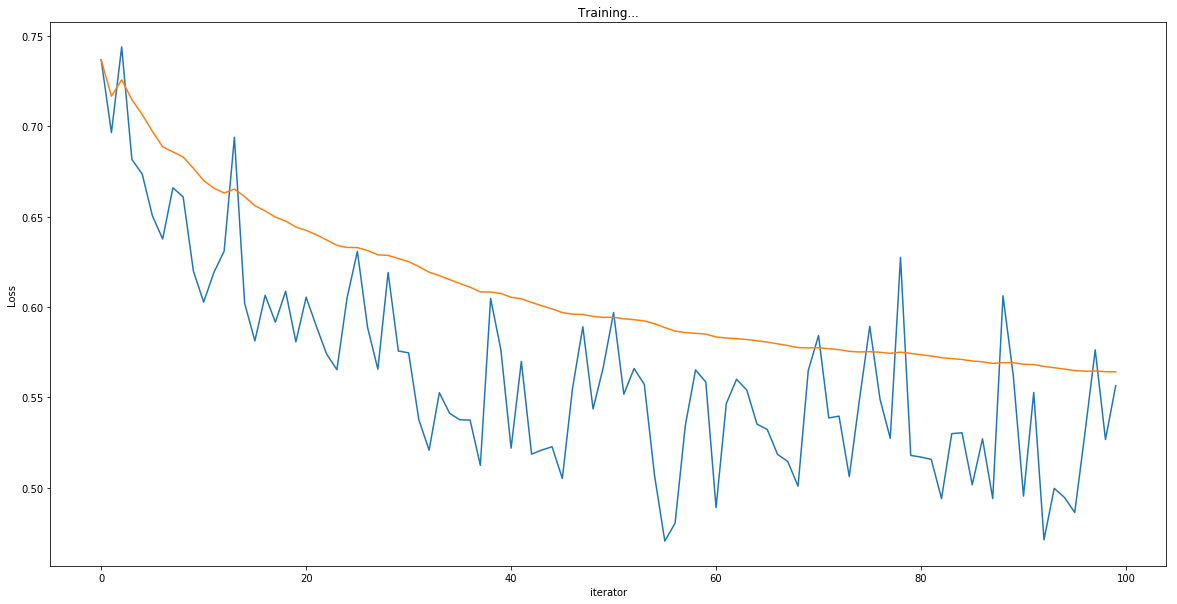

In [39]:
############ 训练模型
import torch.optim as optim
import matplotlib.pyplot as plt
ESIM_model = ESIM().float().cuda()
ESIM_model.apply(weights_init)  ############ weight init
max_epochs = 2
optimizer = optim.Adam(ESIM_model.parameters(), lr=0.001)
lossFunc = nn.CrossEntropyLoss()
cal_loss_list = []
cal_mean_loss_list = []

count = 0
for epoch in range(max_epochs):
    for batch_q,batch_q_len,batch_t,batch_t_len,batch_label,batch_lgb in train_data_generator:
        var_q = torch.from_numpy(batch_q).long().cuda()
        var_q_len = torch.from_numpy(batch_q_len).int().cuda()
        var_t = torch.from_numpy(batch_t).long().cuda()
        var_t_len = torch.from_numpy(batch_t_len).int().cuda()
        var_lgb = torch.from_numpy(batch_lgb).float().cuda()
        var_label = torch.from_numpy(batch_label).cuda()
        
        optimizer.zero_grad()
        outputs = ESIM_model(var_q,var_q_len,var_t,var_t_len,var_lgb)
        loss = lossFunc(outputs,var_label)
        loss.backward()
        optimizer.step()

        running_loss = loss.item()
        cal_loss_list.append(running_loss)
        count += 1
        if(count<100):
            cal_mean_loss_list.append(sum(cal_loss_list)/len(cal_loss_list))
        else:
            cal_mean_loss_list.append(sum(cal_loss_list[-100:])/100)
            
        if(count%10 == 0):
            plot(cal_loss_list,cal_mean_loss_list)
        
        if(count%100 == 0):
            torch.save(ESIM_model.state_dict(),model_path+"ESIM.model")
#             print(cal_mean_loss_list[-1])

In [40]:
print(ESIM_model.state_dict())
torch.save(ESIM_model.state_dict(),model_path+"ESIM.model")
print('Finished Training')
pickle.dump(ESIM_model,open(model_path+"ESIM_model.pkl","wb"))

OrderedDict([('_embed_layer.weight', tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.4850,  0.0935, -0.3553,  ..., -0.2367, -0.1862,  0.1761],
        [-0.4619,  0.4928, -0.0408,  ..., -0.0416, -0.5465,  0.7217],
        ...,
        [-0.3156,  0.6196, -0.0124,  ...,  0.0815,  0.0677,  0.1813],
        [-0.3212,  0.2862, -0.5207,  ...,  0.4140,  0.4838,  0.1738],
        [ 0.2259, -0.0556, -0.1790,  ..., -0.1296,  0.3714,  0.4857]],
       device='cuda:3')), ('_encoding_layer1._encoder.weight_ih_l0', tensor([[-0.0219, -0.0606,  0.0730,  ...,  0.0782,  0.0699,  0.0308],
        [-0.0031,  0.0048, -0.0621,  ...,  0.0095,  0.0825, -0.0616],
        [-0.0240,  0.0050,  0.0099,  ..., -0.0402,  0.0270, -0.0709],
        ...,
        [-0.0478, -0.0355, -0.0555,  ...,  0.0237,  0.0600,  0.0559],
        [ 0.0088,  0.0467, -0.0437,  ..., -0.0291, -0.0507,  0.0306],
        [-0.0335, -0.0698,  0.0271,  ..., -0.0194,  0.0039,  0.0554]],
       device='cuda:3')), 

In [41]:
test_model = ESIM().float().cuda()
state_dict = torch.load(model_path+"ESIM.model")
test_model.load_state_dict(state_dict)
test_model = test_model.eval().cuda()

y_true = []
ans = []
with torch.no_grad():
    for batch_q,batch_q_len,batch_t,batch_t_len,batch_label,batch_lgb in train_data_generator:
        var_q = torch.from_numpy(batch_q).long().cuda()
        var_q_len = torch.from_numpy(batch_q_len).int().cuda()
        var_t = torch.from_numpy(batch_t).long().cuda()
        var_t_len = torch.from_numpy(batch_t_len).int().cuda()
        var_lgb = torch.from_numpy(batch_lgb).float().cuda()
        var_label = torch.from_numpy(batch_label)
        
        predict = test_model(var_q,var_q_len,var_t,var_t_len,var_lgb)
        predict = F.softmax(predict,dim=1).detach().cpu()
        ans.extend(predict[:,1].data.tolist())
        y_true.extend(batch_label)

        
ans = np.array(ans)        
print(len(ans))
print(ans[:10])
print(len(y_true))
print(y_true[:10])

from sklearn.metrics import roc_auc_score
# ############################################### 存在Nan值
# for i in ~np.isfinite(ans):
#     if i:
#         print(i)

ans[~np.isfinite(ans)] = 0
print(ans.shape)
roc_auc_score(y_true, ans)

12701
[0.18092065 0.50006026 0.44269672 0.1146962  0.11800654 0.33295068
 0.14654617 0.16192147 0.10751366 0.11520118]
12701
[0, 1, 1, 0, 1, 0, 0, 0, 0, 0]
(12701,)


0.6898913024735631